In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import qgrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_kernels
import seaborn as sns

### Source Domain

In [2]:
rating_dataset = pd.read_csv("ratings.csv")
rating_dataset = rating_dataset.drop(columns =['timestamp'])
rating_dataset.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [3]:
movie_dataset = pd.read_csv("movies.csv")
movie_dataset.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data = pd.merge(rating_dataset,movie_dataset, left_on='movieId',right_on ='movieId',how='left') 
unique_user = np.unique(data['userId'])
count =0 
final_data = pd.DataFrame(columns = ['userId','movieId','rating','title','genres'])
for i in range(len(unique_user)):
    if unique_user[count] <= 100:
        rows = data.loc[data['userId'] == unique_user[count]].head(random.randrange(2, 4))
        new_data = pd.DataFrame(np.array(rows),columns=['userId','movieId','rating','title','genres'])
        final_data = final_data.append(new_data)
        count += 1
    else:
        break
final_data = final_data.reset_index(drop=True)
final_data = final_data.astype({"userId": int, "movieId": int,'rating': float, 'title':str, 'genres':str })    
final_data.to_csv('Final_Dataset.csv',index=False)
final_data.head(6)

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,2,3,4.0,Grumpier Old Men (1995),Comedy|Romance
4,2,62,5.0,Mr. Holland's Opus (1995),Drama
5,3,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Data Visualization

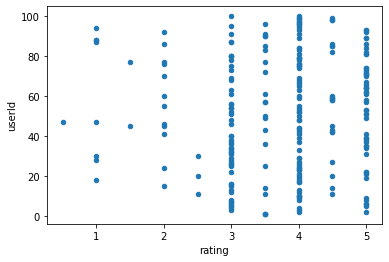

In [5]:
final_data.plot.scatter(x='rating', y='userId')                         #Plotting rating vs userId
plt.xlabel('rating')
plt.ylabel('userId')
plt.show()

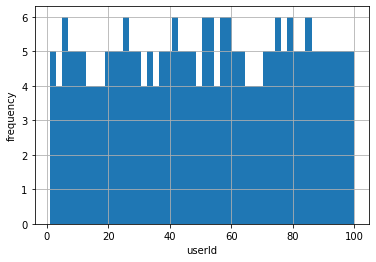

In [6]:
final_data['userId'].hist(bins= 50)                                     #Plotting userId vs frequency
plt.xlabel('userId')
plt.ylabel('frequency')
plt.show()

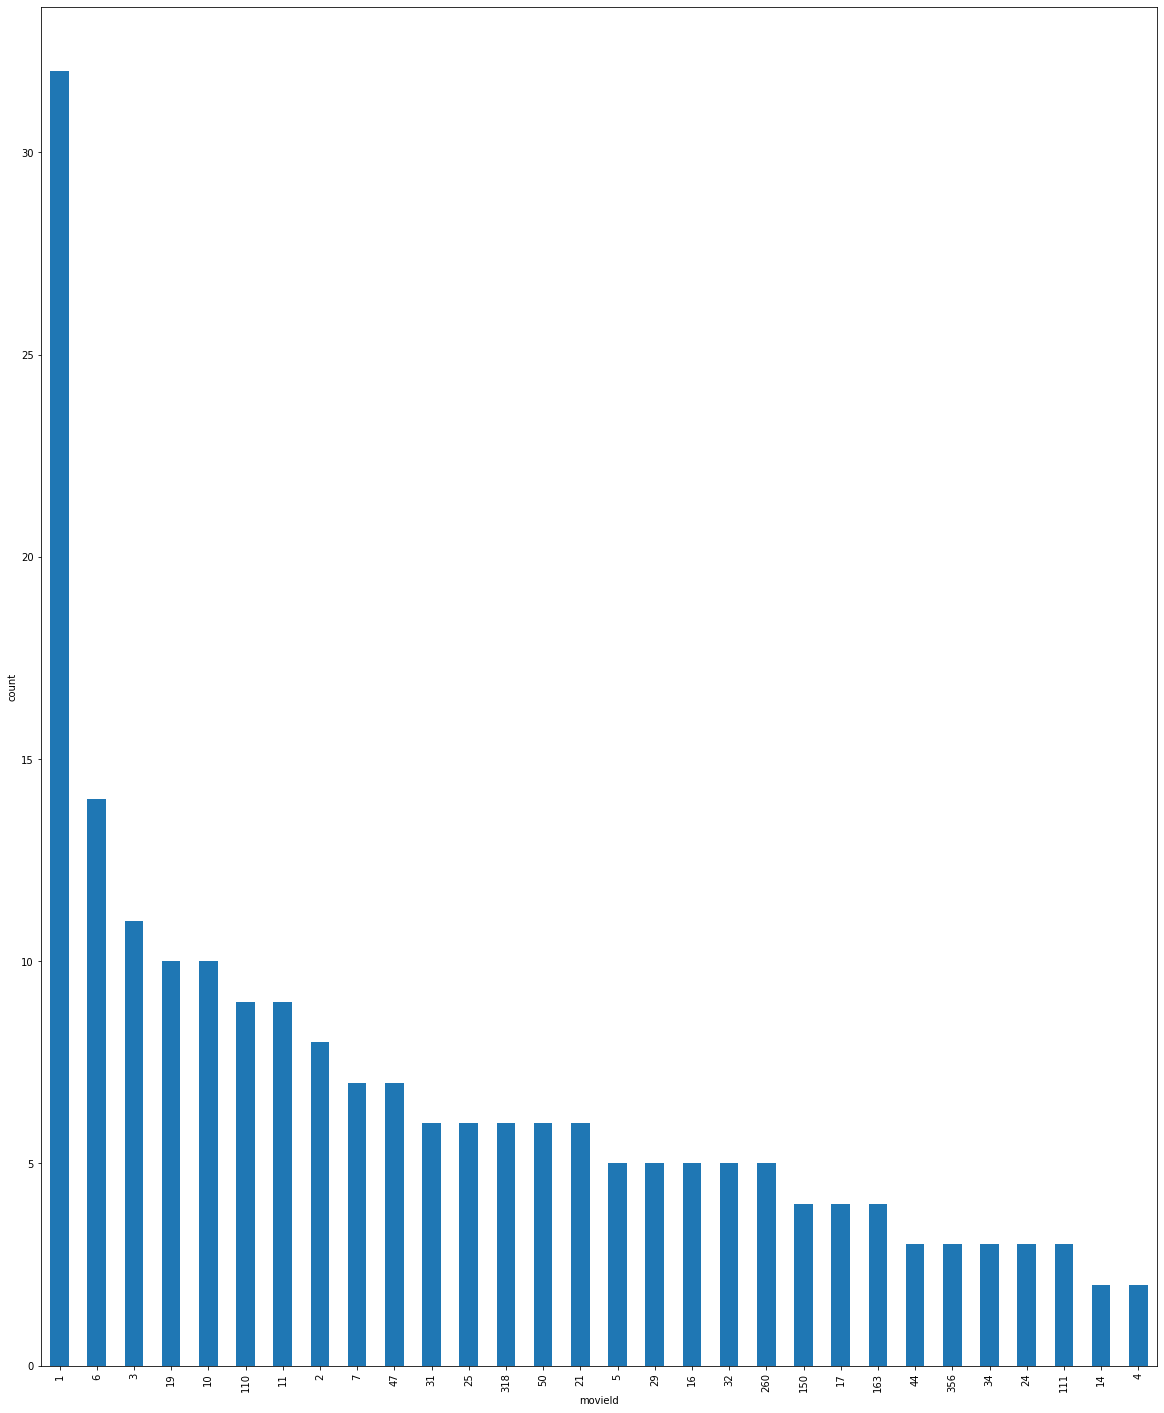

In [7]:
final_data['movieId'].value_counts().head(30).plot(kind='bar',figsize =(20,25))     #Plotting moveId vs count
plt.xlabel('movieId')
plt.ylabel('count')
plt.show()

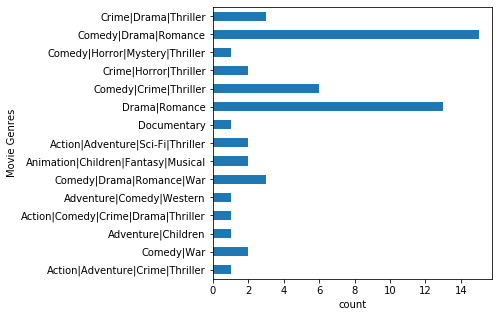

In [8]:
final_data['genres'].value_counts().sample(15).plot(kind='barh',figsize =(5,5))    #Plotting movie genres vs count
plt.xlabel('count')
plt.ylabel('Movie Genres')
plt.show()

### Data Pre-Processing

In [9]:
final_data = pd.read_csv("Final_Dataset.csv")

In [10]:
final_data.isnull().values.any()                   # check if there is any data in any column missing or not available

False

In [11]:
# find threshold by averging the movie ratings
# get only top5 rated movies per user,threshold is 4.5

maxRating = final_data.loc[final_data['rating'].idxmax()]['rating'] 
toprated_user_movies = final_data.loc[final_data['rating'] >= maxRating/2+1]
toprated_user_movies = toprated_user_movies.sort_values(['userId','rating'],ascending=[True,False])
toprated_user_movies.reset_index(inplace=True, drop=True)
toprated_user_movies.head()

# checking if user has rated a movie multiple times
#toprated_user_movies.duplicated(subset=['userId','movieId'])
# actual data is 20000263 after this step it is 646297

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,2,62,5.0,Mr. Holland's Opus (1995),Drama
4,2,3,4.0,Grumpier Old Men (1995),Comedy|Romance


In [12]:
#Extracting Unique Genres

unique_genres_pre = pd.DataFrame(columns=['genres'])
unique_genres_pre['genres'] = toprated_user_movies['genres'].unique()
unique_genres_pre['genres'] = unique_genres_pre['genres'].str.split('|')
unique_genres = unique_genres_pre['genres']
print(len(unique_genres))

40


In [13]:
# Break up the big genre string into a string array

toprated_user_movies['genres'] = toprated_user_movies['genres'].str.split('|')

# Convert genres to string value

toprated_user_movies['genres'] = toprated_user_movies['genres'].str.join(',')
toprated_user_movies.head()

qwidget2 = qgrid.show_grid(toprated_user_movies,show_toolbar=True)
qwidget2



QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Target Domain

In [14]:
books = pd.read_csv('book_data.csv')
books.head(6)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...


### Data Visualization 

54301


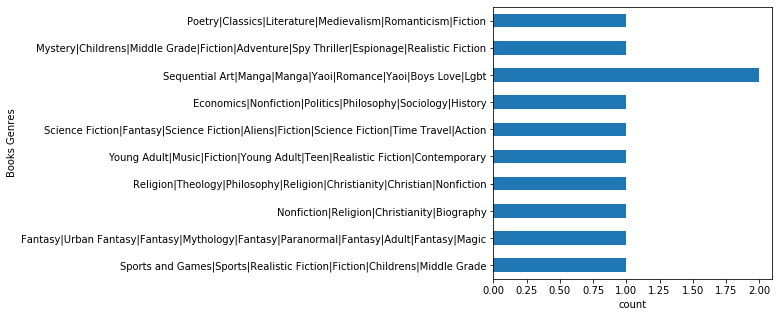

In [15]:
print(len(books['genres']))
books['genres'].value_counts().sample(10).plot(kind='barh',figsize =(5,5))    #Plotting books genres vs count
plt.xlabel('count')
plt.ylabel('Books Genres')
plt.show()

Text(0, 0.5, 'frequency')

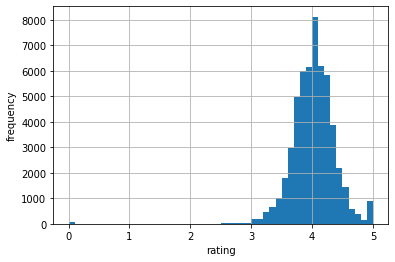

In [16]:
books['book_rating'].hist(bins= 50)                                           #Plotting books rating vs frequency
plt.xlabel('rating')
plt.ylabel('frequency')

### Data Pre-processing

In [17]:
#target domain

books = pd.read_csv('book_data.csv')
books = books[['book_title','genres','book_rating']]
books = books.dropna(how='any', axis=0)

# Break up the big genre string into a string array

books['genres'] = books['genres'].str.split('|')

# Convert genres to string value

books['genres'] = np.array(books['genres'])
books['length'] = books['genres'].str.len()
books = books.sort_values(['length'])
books = books.drop(columns = ['length'])
maxRating_book = books.loc[books['book_rating'].idxmax()]['book_rating'] 
books = books.loc[books['book_rating'] >= maxRating_book/2+1]
books.reset_index(inplace=True, drop=True)
books.head(5)

,book_title,genres,book_rating
0,الأيام,[Biography],3.53
1,Biological Big Bang: Panspermia and the Origin...,[Nonfiction],4.50
2,Mugglenet.Com's What Will Happen in Harry Pott...,[Nonfiction],4.20
3,"Crónica del rey cautivo (El último Qassatar, #1)",[Fantasy],4.13
4,Here Before Kilroy,[Fiction],5.00


### Training the Model 

In [18]:
 # finding intersection and recommending books
    
def book_basedon_movie(genre):
    data = []
    book_titles = []
    scores = []
    ratings = []
    book_genres = []
    for i,row in books.iterrows():
        movies_set = set(genre)
        books_set = set(row.genres)
        intersection = movies_set.intersection(books_set)
        book_titles.append(row.book_title)
        ratings.append(row.book_rating)
        book_genres.append(row.genres)
        scores.append(float(len(intersection))/(len(movies_set)+len(books_set)-len(intersection)))
    final = pd.DataFrame(columns = ['book_title','score','ratings','book_genres'])
    final['book_title'] = book_titles
    final['score'] = scores
    final['ratings'] = ratings
    final['book_genres'] = book_genres
    return final

In [19]:
df_books_movies = pd.DataFrame(columns=['genres','books'])
size = len(unique_genres)
books_array = []
genres = []
for i in range(size):
    book_df = book_basedon_movie(unique_genres[i])
    book_df = book_df.sort_values(['score','ratings'],ascending=[False,False]).head(5)
    books_array.append(','.join([str(elem) for elem in book_df['book_title']]))
    genres.append(','.join(unique_genres[i]))
df_books_movies['genres'] = genres
df_books_movies['books'] = books_array
df_books_movies.head()


,genres,books
0,"Adventure,Children,Fantasy",Selections from Harry Potter and the Order of ...
1,"Adventure,Drama,Fantasy,Mystery,Sci-Fi","The 39 Clues Complete Collection,This Book Is ..."
2,"Mystery,Sci-Fi,Thriller","Shannon's Land,Rain of Terror,Repercussions,Do..."
3,Drama,"Miss Perfect,Bluesday,Gabriel's Gate,Diabulus ..."
4,"Comedy,Romance","Shadowed Love,Illusory Love IV,Grosvenor Squar..."


In [20]:
final = pd.merge(toprated_user_movies,df_books_movies, left_on='genres',right_on ='genres',how='left')
final = final.dropna()
final.to_csv('Recommended_Dataset.csv',index=False)
print(final.isnull().values.any())
final.head()

False


,userId,movieId,rating,title,genres,books
0,1,2,3.5,Jumanji (1995),"Adventure,Children,Fantasy",Selections from Harry Potter and the Order of ...
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...","Adventure,Drama,Fantasy,Mystery,Sci-Fi","The 39 Clues Complete Collection,This Book Is ..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Mystery,Sci-Fi,Thriller","Shannon's Land,Rain of Terror,Repercussions,Do..."
3,2,62,5.0,Mr. Holland's Opus (1995),Drama,"Miss Perfect,Bluesday,Gabriel's Gate,Diabulus ..."
4,2,3,4.0,Grumpier Old Men (1995),"Comedy,Romance","Shadowed Love,Illusory Love IV,Grosvenor Squar..."


In [21]:
output_data = pd.read_csv('Recommended_Dataset.csv')
output_data['books'] = output_data['books'].str.split(',')
output_data.head()

,userId,movieId,rating,title,genres,books
0,1,2,3.5,Jumanji (1995),"Adventure,Children,Fantasy",[Selections from Harry Potter and the Order of...
1,1,29,3.5,"City of Lost Children, The (Cité des enfants p...","Adventure,Drama,Fantasy,Mystery,Sci-Fi","[The 39 Clues Complete Collection, This Book I..."
2,1,32,3.5,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Mystery,Sci-Fi,Thriller","[Shannon's Land, Rain of Terror, Repercussions..."
3,2,62,5.0,Mr. Holland's Opus (1995),Drama,"[Miss Perfect, Bluesday, Gabriel's Gate, Diabu..."
4,2,3,4.0,Grumpier Old Men (1995),"Comedy,Romance","[Shadowed Love, Illusory Love IV, Grosvenor Sq..."


In [22]:
#testing the model using genre input 

print(df_books_movies.loc[df_books_movies['genres']=='Adventure,Children,Fantasy'])

                       genres  \
0  Adventure,Children,Fantasy   

                                               books  
0  Selections from Harry Potter and the Order of ...  


### Evaluation

In [23]:
book_ds_csv = pd.DataFrame(columns=['userId','books'])
books_array = []
users = []
genres = []
def books_for_users(userID,size):
    book = np.array(output_data.loc[output_data['userId']==userID]['books'])
    for i in range(size):
        users.append(userID)
        books_array.append(book[i])    
unique_user = np.unique(output_data['userId'])


      
for j in range(5):
    size = len(output_data.loc[output_data['userId']==unique_user[j]]) 
    books_for_users(unique_user[j],size)

book_ds_csv['userId'] = users
book_ds_csv['books'] = books_array
book_ds_csv.head()

,userId,books
0,1,[Selections from Harry Potter and the Order of...
1,1,"[The 39 Clues Complete Collection, This Book I..."
2,1,"[Shannon's Land, Rain of Terror, Repercussions..."
3,2,"[Miss Perfect, Bluesday, Gabriel's Gate, Diabu..."
4,2,"[Shadowed Love, Illusory Love IV, Grosvenor Sq..."


In [24]:
book_ds_csv.to_csv('Survey_Dataset.csv',index=False)                         #For survey purpose

In [25]:
survey_data = pd.read_excel('Consolidated_Survey_Response.xlsx')
survey_data.head(20)

,userId,book_title,actual_rating
0,1,Selections from Harry Potter and the Order of ...,3.5
1,1,Jeweler's Apprentice,4.4
2,1,Waterwight,5.0
3,1,Heritage of the Xandim,3.3
4,1,Captain Sinbad,5.0
5,1,The 39 Clues Complete Collection,4.2
6,1,This Book Is Not Good for You,3.5
7,1,If You're Reading This,3.8
8,1,It's Too Late,4.8
9,1,The Pretender's Gambit,5.0


Text(0, 0.5, 'frequency')

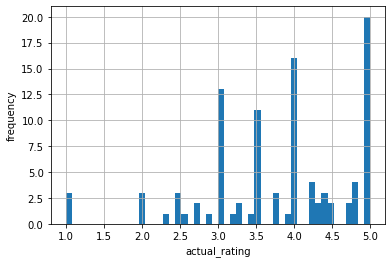

In [26]:
survey_data['actual_rating'].hist(bins= 50)
plt.xlabel('actual_rating')
plt.ylabel('frequency')

In [27]:
accuracy_score = []
user = []
def estimation_score(userID):
    final_list = list(filter(lambda x: (x>maxRating_book/2+1) , survey_data.loc[survey_data['userId']==userID]['actual_rating']))
    size = len(survey_data.loc[survey_data['userId']==userID]['actual_rating'])
    user.append(userID)
    accuracy_score.append(len(final_list)/size)
users_survey = survey_data['userId'].unique()
for i in range(len(users_survey)):
    estimation_score(users_survey[i])
    
evaluation_ds = pd.DataFrame(columns=['userId','score'])
evaluation_ds['userId'] = user
evaluation_ds['score'] = accuracy_score
print(evaluation_ds)

   userId     score
0       1  0.636364
1       2  0.562500
2       3  0.500000
3       4  0.400000
4       5  0.200000
5       6  0.900000
6       8  0.900000
7       9  0.400000
8      10  0.500000
9      11  0.500000


Text(0, 0.5, 'accuracy score')

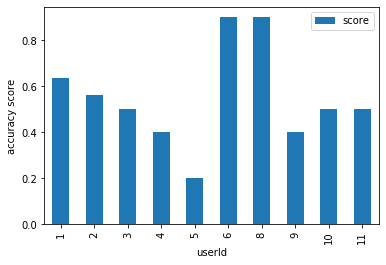

In [28]:
evaluation_ds.plot.bar(y='score',x = 'userId')
plt.ylabel('accuracy score')

In [29]:
evaluate_books = pd.merge(survey_data,books,left_on='book_title',right_on ='book_title',how='left')
evaluate_books = evaluate_books.drop(columns =['book_rating'])
evaluate_books = evaluate_books.dropna()
evaluate_books.head()

,userId,book_title,actual_rating,genres
0,1,Selections from Harry Potter and the Order of ...,3.5,"[Fantasy, Adventure]"
1,1,Jeweler's Apprentice,4.4,"[Fantasy, Adventure]"
2,1,Waterwight,5.0,"[Fantasy, Adventure]"
3,1,Heritage of the Xandim,3.3,"[Fantasy, Adventure]"
4,1,Captain Sinbad,5.0,"[Fantasy, Adventure]"


In [30]:
evaluate_books['genres'] = evaluate_books['genres'].str.join(',')
evaluate_books.head()

,userId,book_title,actual_rating,genres
0,1,Selections from Harry Potter and the Order of ...,3.5,"Fantasy,Adventure"
1,1,Jeweler's Apprentice,4.4,"Fantasy,Adventure"
2,1,Waterwight,5.0,"Fantasy,Adventure"
3,1,Heritage of the Xandim,3.3,"Fantasy,Adventure"
4,1,Captain Sinbad,5.0,"Fantasy,Adventure"


In [31]:
def get_genres(userID):
    genres_of_rec_books = evaluate_books.loc[evaluate_books['userId']==userID]['genres']
    return genres_of_rec_books
rec_genres_matrix =get_genres(1)

# Finding similarity between books using linear metric.

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(rec_genres_matrix)
linear_similarity_matrix =  pairwise_kernels(tfidf_matrix, tfidf_matrix, metric='linear')  
print(linear_similarity_matrix)

[[1.         1.         1.         1.         1.         0.37034828
  0.45351023 0.45351023 0.3057739 ]
 [1.         1.         1.         1.         1.         0.37034828
  0.45351023 0.45351023 0.3057739 ]
 [1.         1.         1.         1.         1.         0.37034828
  0.45351023 0.45351023 0.3057739 ]
 [1.         1.         1.         1.         1.         0.37034828
  0.45351023 0.45351023 0.3057739 ]
 [1.         1.         1.         1.         1.         0.37034828
  0.45351023 0.45351023 0.3057739 ]
 [0.37034828 0.37034828 0.37034828 0.37034828 0.37034828 1.
  0.40870149 0.40870149 0.82563878]
 [0.45351023 0.45351023 0.45351023 0.45351023 0.45351023 0.40870149
  1.         1.         0.3374398 ]
 [0.45351023 0.45351023 0.45351023 0.45351023 0.45351023 0.40870149
  1.         1.         0.3374398 ]
 [0.3057739  0.3057739  0.3057739  0.3057739  0.3057739  0.82563878
  0.3374398  0.3374398  1.        ]]


[Text(33.0, 0.5, 'book genre'), Text(0.5, 15.0, 'book genre')]

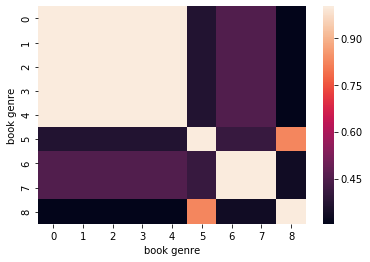

In [32]:
fig = sns.heatmap(linear_similarity_matrix)
fig.set(xlabel='book genre', ylabel='book genre')

[[1.         1.         1.         1.         1.         0.83535333
  0.85543948 0.85543948 0.82008252]
 [1.         1.         1.         1.         1.         0.83535333
  0.85543948 0.85543948 0.82008252]
 [1.         1.         1.         1.         1.         0.83535333
  0.85543948 0.85543948 0.82008252]
 [1.         1.         1.         1.         1.         0.83535333
  0.85543948 0.85543948 0.82008252]
 [1.         1.         1.         1.         1.         0.83535333
  0.85543948 0.85543948 0.82008252]
 [0.83535333 0.83535333 0.83535333 0.83535333 0.83535333 1.
  0.84455752 0.84455752 0.95140305]
 [0.85543948 0.85543948 0.85543948 0.85543948 0.85543948 0.84455752
  1.         1.         0.8275358 ]
 [0.85543948 0.85543948 0.85543948 0.85543948 0.85543948 0.84455752
  1.         1.         0.8275358 ]
 [0.82008252 0.82008252 0.82008252 0.82008252 0.82008252 0.95140305
  0.8275358  0.8275358  1.        ]]


[Text(33.0, 0.5, 'book genre'), Text(0.5, 15.0, 'book genre')]

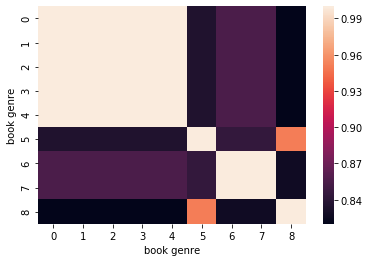

In [33]:
# Finding similarity between books using RBF metric.

rbf_similarity_matrix =  pairwise_kernels(tfidf_matrix, tfidf_matrix, metric='rbf')
print(rbf_similarity_matrix)
fig = sns.heatmap(rbf_similarity_matrix)
fig.set(xlabel='book genre', ylabel='book genre')

[[0.81537394 0.81537394 0.81537394 0.81537394 0.81537394 0.78293393
  0.78748919 0.78748919 0.77933789]
 [0.81537394 0.81537394 0.81537394 0.81537394 0.81537394 0.78293393
  0.78748919 0.78748919 0.77933789]
 [0.81537394 0.81537394 0.81537394 0.81537394 0.81537394 0.78293393
  0.78748919 0.78748919 0.77933789]
 [0.81537394 0.81537394 0.81537394 0.81537394 0.81537394 0.78293393
  0.78748919 0.78748919 0.77933789]
 [0.81537394 0.81537394 0.81537394 0.81537394 0.81537394 0.78293393
  0.78748919 0.78748919 0.77933789]
 [0.78293393 0.78293393 0.78293393 0.78293393 0.78293393 0.81537394
  0.78504532 0.78504532 0.80685412]
 [0.78748919 0.78748919 0.78748919 0.78748919 0.78748919 0.78504532
  0.81537394 0.81537394 0.78110779]
 [0.78748919 0.78748919 0.78748919 0.78748919 0.78748919 0.78504532
  0.81537394 0.81537394 0.78110779]
 [0.77933789 0.77933789 0.77933789 0.77933789 0.77933789 0.80685412
  0.78110779 0.78110779 0.81537394]]


[Text(33.0, 0.5, 'book genre'), Text(0.5, 15.0, 'book genre')]

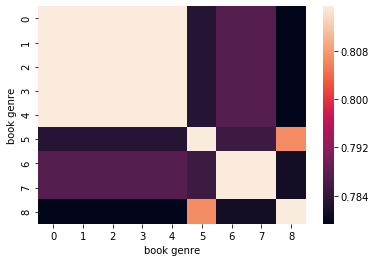

In [34]:
# Finding similarity between books using Sigmoid metric.

sigmoid_similarity_matrix =  pairwise_kernels(tfidf_matrix, tfidf_matrix, metric='sigmoid')
print(sigmoid_similarity_matrix)
fig = sns.heatmap(sigmoid_similarity_matrix)
fig.set(xlabel='book genre', ylabel='book genre')

[[1.         1.         1.         1.         1.         0.70085394
  0.7490569  0.7490569  0.66411216]
 [1.         1.         1.         1.         1.         0.70085394
  0.7490569  0.7490569  0.66411216]
 [1.         1.         1.         1.         1.         0.70085394
  0.7490569  0.7490569  0.66411216]
 [1.         1.         1.         1.         1.         0.70085394
  0.7490569  0.7490569  0.66411216]
 [1.         1.         1.         1.         1.         0.70085394
  0.7490569  0.7490569  0.66411216]
 [0.70085394 0.70085394 0.70085394 0.70085394 0.70085394 1.
  0.74312068 0.74312068 0.87507711]
 [0.7490569  0.7490569  0.7490569  0.7490569  0.7490569  0.74312068
  1.         1.         0.68877952]
 [0.7490569  0.7490569  0.7490569  0.7490569  0.7490569  0.74312068
  1.         1.         0.68877952]
 [0.66411216 0.66411216 0.66411216 0.66411216 0.66411216 0.87507711
  0.68877952 0.68877952 1.        ]]


[Text(33.0, 0.5, 'book genre'), Text(0.5, 15.0, 'book genre')]

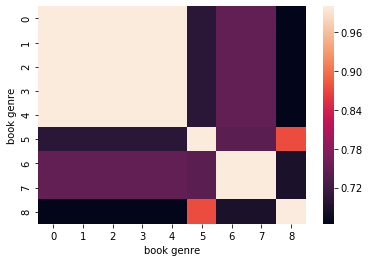

In [35]:
# Finding similarity between books using Laplacian metric.

laplacian_similarity_matrix =  pairwise_kernels(tfidf_matrix, tfidf_matrix, metric='laplacian')
print(laplacian_similarity_matrix)
fig = sns.heatmap(laplacian_similarity_matrix)
fig.set(xlabel='book genre', ylabel='book genre')

In [36]:
data_display = output_data.drop(columns=['movieId','rating'])
qwidget = qgrid.show_grid(data_display,show_toolbar=True)
qwidget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [37]:
qwidget2 = qgrid.show_grid(evaluation_ds,show_toolbar=True)
qwidget2

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…